<a href="https://colab.research.google.com/github/SelinErcan/MachineLearning/blob/main/DT_Implementation_on_Abalone_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold 
import numpy
from sklearn.metrics import confusion_matrix
import seaborn as sn
import math
from sklearn.metrics import accuracy_score

## Part 1: Load Dataset
Load the data and performa a quick analysis of what it is and what features it has.

In [ ]:
def loadDataset():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
    names = ['sex', 'length','diameter', 'height','whole weight','shucked weight','viscera weight','shell weight','rings']
      
    dataset = pd.read_csv(url, names=names)
    print(dataset.head())

              
    array= dataset.values 
    X = array[:,1:8]
    y = array[:,0] 
    
    attribute_types = [];    #this code block finds colomns feature types.
    for i in range(len(names)) :
        if dataset[names[i]].dtype == "object":
            datatype= "categorical"
        else :
            datatype = "numeric"
        print("Feature:",names[i]," - Datatype:",datatype)
        attribute_types.append(datatype)
        
    return X, y, attribute_types
    

In [ ]:
X, y, attribute_types = loadDataset()

  sex  length  diameter  ...  viscera weight  shell weight  rings
0   M   0.455     0.365  ...          0.1010         0.150     15
1   M   0.350     0.265  ...          0.0485         0.070      7
2   F   0.530     0.420  ...          0.1415         0.210      9
3   M   0.440     0.365  ...          0.1140         0.155     10
4   I   0.330     0.255  ...          0.0395         0.055      7

[5 rows x 9 columns]
Feature: sex  - Datatype: categorical
Feature: length  - Datatype: numeric
Feature: diameter  - Datatype: numeric
Feature: height  - Datatype: numeric
Feature: whole weight  - Datatype: numeric
Feature: shucked weight  - Datatype: numeric
Feature: viscera weight  - Datatype: numeric
Feature: shell weight  - Datatype: numeric
Feature: rings  - Datatype: numeric


## Part 2: Implement build_dt function

In [ ]:
def attribute_type_change(X,attribute_types):  #if feature is categorical, this function changes categorical data to numeric. 
    for i in range(len(X[0])):
        if attribute_types[i+1] == "categorical":
            values=[]
            values.append(X[0][i])
            for j in range(len(X)):
                for k in range(len(values)):
                    if(X[j,i]==values[k]):  #if data is defined before, it does not add the value to values list and gives its index value to X as a new numeric data.
                        X[j,i]=k
                if X[j,i] != k:     #if data is not defined before, it adds data to values list and gives index value to X as a numeric data.
                    values.append(X[j,i])
                    X[j,i]= len(values)
    return X

In [ ]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
    # count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
    return gini
 
# Select the best split point for a dataset
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}
 
# Create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

In [ ]:
# Build a decision tree
def build_dt(X_train, y_train, attribute_types, max_depth=5, min_size=10):
    
    X_train = attribute_type_change(X_train,attribute_types) #changes categorical values to numeric.
    #combines X and y feature to do calculations
    uni_train=numpy.array(y_train).reshape(len(X_train),1)
    dataset=numpy.hstack((X_train, uni_train))      
                
                
    root = get_split(dataset)
    split(root, max_depth, min_size, 1)
    return root

## Part 3: Implement predict_dt function

In [ ]:
# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']
        
# Print a decision tree
def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))

In [ ]:
def predict_dt(tree, X_test, attribute_types):
    predictions = list()   
    X_test = attribute_type_change(X_test,attribute_types) #changes categorical values to numeric.
    
    for row in X_test:
        prediction = predict(tree, row)
        predictions.append(prediction)
    return(predictions)

## Part 4: Cross Validation Results
Report the performance of your implementation using an appropriate k-fold cross validation using confusion matrices on the given dataset.  

In [ ]:
def applyDT(X, y, prune=False):

    scores = list()
    
    kf = KFold(n_splits=5, random_state=None, shuffle=True) #k-fold cross validation with value 10.
    split = kf.get_n_splits(X)
    print("\nK-fold cross validation split:",split) 
    
    for train_index, test_index in kf.split(X):   #splits the data to train and test data by given k value.
        
        X_train, X_test = X[train_index], X[test_index]   
        y_train, y_test = y[train_index], y[test_index]

        if prune:
            max_depth, min_size = pruneDT(X_train, y_train, X_test, y_test)
            tree=build_dt(X_train, y_train, attribute_types, max_depth, min_size)
        else: 
            tree=build_dt(X_train, y_train, attribute_types)
        
        print("-------------------------------------")
        print_tree(tree)
        predictions=predict_dt(tree, X_test, attribute_types)

        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        
        print("Confusion matrix:")
        confMatrix = confusion_matrix(y_test, predictions)   #make confusion matrix by predictions and the true result
        df_cm = pd.DataFrame(confMatrix)
        sn.heatmap(df_cm, annot=True, fmt=".1f") 
        plt.show()

        print('Accuracy: %s' % accuracy)
        
    print("-------------------------------------")    
    print('Scores: %s' % scores)
    return np.mean(scores)


K-fold cross validation split: 5
-------------------------------------
[X6 < 0.144]
 [X3 < 0.115]
  [X7 < 0.129]
   [X3 < 0.105]
    [X2 < 0.360]
     [I]
     [M]
    [X1 < 0.415]
     [I]
     [I]
   [X1 < 0.475]
    [X6 < 0.081]
     [I]
     [M]
    [X6 < 0.101]
     [I]
     [I]
  [X1 < 0.510]
   [X6 < 0.106]
    [X4 < 0.551]
     [I]
     [M]
    [X5 < 0.198]
     [F]
     [M]
   [X4 < 0.676]
    [X3 < 0.170]
     [I]
     [F]
    [X2 < 0.455]
     [I]
     [F]
 [X4 < 0.946]
  [X4 < 0.825]
   [X1 < 0.540]
    [X5 < 0.327]
     [F]
     [M]
    [X3 < 0.125]
     [M]
     [I]
   [X7 < 0.345]
    [X5 < 0.275]
     [M]
     [M]
    [M]
  [X5 < 0.875]
   [X2 < 0.545]
    [X2 < 0.415]
     [M]
     [M]
    [X1 < 0.755]
     [F]
     [M]
   [X2 < 0.625]
    [X5 < 0.903]
     [M]
     [M]
    [F]
Confusion matrix:


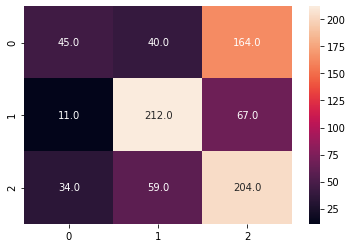

Accuracy: 0.5514354066985646
-------------------------------------
[X6 < 0.148]
 [X7 < 0.129]
  [X7 < 0.068]
   [X1 < 0.355]
    [X3 < 0.080]
     [I]
     [I]
    [X1 < 0.365]
     [I]
     [I]
   [X5 < 0.148]
    [X6 < 0.085]
     [I]
     [M]
    [X6 < 0.096]
     [I]
     [I]
  [X1 < 0.515]
   [X3 < 0.130]
    [X1 < 0.475]
     [I]
     [I]
    [X6 < 0.114]
     [I]
     [F]
   [X4 < 0.702]
    [X7 < 0.200]
     [I]
     [I]
    [X7 < 0.267]
     [I]
     [F]
 [X4 < 0.945]
  [X7 < 0.325]
   [X6 < 0.169]
    [X2 < 0.425]
     [M]
     [I]
    [X4 < 0.823]
     [F]
     [M]
   [X1 < 0.590]
    [X1 < 0.545]
     [M]
     [M]
    [I]
  [X5 < 0.874]
   [X6 < 0.312]
    [X5 < 0.615]
     [M]
     [M]
    [X1 < 0.735]
     [F]
     [M]
   [X1 < 0.800]
    [X3 < 0.175]
     [F]
     [M]
    [F]
Confusion matrix:


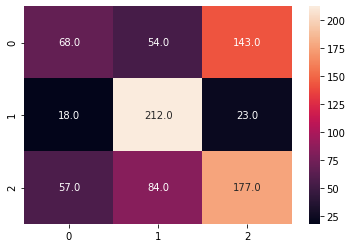

Accuracy: 0.5466507177033493
-------------------------------------
[X6 < 0.144]
 [X7 < 0.129]
  [X3 < 0.105]
   [X3 < 0.075]
    [X2 < 0.255]
     [I]
     [I]
    [X5 < 0.086]
     [I]
     [I]
   [X1 < 0.420]
    [X4 < 0.222]
     [I]
     [I]
    [X4 < 0.309]
     [M]
     [I]
  [X1 < 0.510]
   [X7 < 0.173]
    [X1 < 0.465]
     [I]
     [I]
    [X7 < 0.215]
     [F]
     [M]
   [X7 < 0.285]
    [X4 < 0.737]
     [I]
     [I]
    [F]
 [X4 < 0.927]
  [X4 < 0.795]
   [X1 < 0.540]
    [X5 < 0.327]
     [F]
     [M]
    [X5 < 0.253]
     [M]
     [I]
   [X4 < 0.817]
    [X1 < 0.550]
     [F]
     [F]
    [X1 < 0.580]
     [M]
     [F]
  [X5 < 0.874]
   [X2 < 0.535]
    [X5 < 0.653]
     [M]
     [M]
    [X4 < 1.844]
     [F]
     [M]
   [X3 < 0.175]
    [F]
    [X2 < 0.610]
     [M]
     [F]
Confusion matrix:


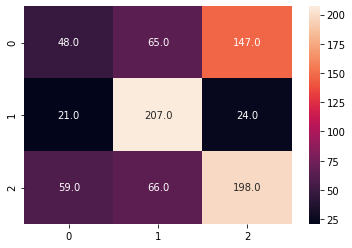

Accuracy: 0.5425149700598803
-------------------------------------
[X6 < 0.149]
 [X7 < 0.116]
  [X3 < 0.120]
   [X1 < 0.420]
    [X7 < 0.095]
     [I]
     [I]
    [X1 < 0.480]
     [I]
     [M]
   [X2 < 0.345]
    [X6 < 0.086]
     [I]
     [M]
    [I]
  [X3 < 0.150]
   [X1 < 0.510]
    [X4 < 0.608]
     [I]
     [M]
    [X4 < 0.736]
     [I]
     [M]
   [X6 < 0.124]
    [X6 < 0.110]
     [I]
     [F]
    [X5 < 0.301]
     [F]
     [M]
 [X4 < 0.875]
  [X1 < 0.540]
   [X6 < 0.173]
    [X3 < 0.165]
     [M]
     [F]
    [X5 < 0.406]
     [F]
     [F]
   [X4 < 0.783]
    [X6 < 0.176]
     [I]
     [F]
    [X5 < 0.449]
     [M]
     [I]
  [X6 < 0.299]
   [X5 < 0.564]
    [X6 < 0.221]
     [M]
     [M]
    [X7 < 0.313]
     [M]
     [M]
   [X5 < 0.867]
    [X5 < 0.818]
     [F]
     [F]
    [X2 < 0.610]
     [M]
     [F]
Confusion matrix:


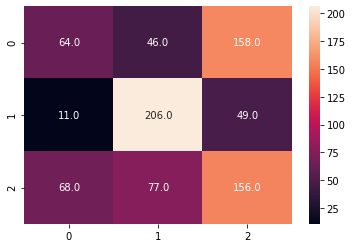

Accuracy: 0.5101796407185629
-------------------------------------
[X6 < 0.144]
 [X6 < 0.088]
  [X3 < 0.075]
   [X6 < 0.011]
    [X3 < 0.040]
     [I]
     [I]
    [X6 < 0.033]
     [I]
     [I]
   [X5 < 0.070]
    [X4 < 0.197]
     [I]
     [M]
    [X3 < 0.115]
     [I]
     [I]
  [X5 < 0.196]
   [X7 < 0.119]
    [X1 < 0.420]
     [F]
     [I]
    [X2 < 0.365]
     [F]
     [I]
   [X4 < 0.629]
    [X6 < 0.114]
     [I]
     [I]
    [X1 < 0.505]
     [M]
     [I]
 [X4 < 0.940]
  [X4 < 0.823]
   [X1 < 0.540]
    [X5 < 0.202]
     [F]
     [M]
    [X5 < 0.253]
     [M]
     [I]
   [X5 < 0.345]
    [X1 < 0.585]
     [M]
     [F]
    [X7 < 0.240]
     [F]
     [M]
  [X5 < 0.874]
   [X2 < 0.545]
    [X3 < 0.160]
     [M]
     [F]
    [X3 < 0.200]
     [F]
     [F]
   [X2 < 0.565]
    [X4 < 1.510]
     [F]
     [M]
    [X6 < 0.541]
     [M]
     [M]
Confusion matrix:


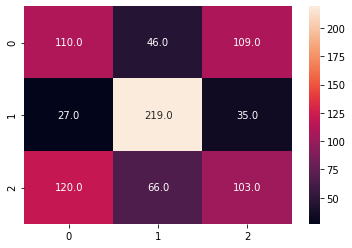

Accuracy: 0.5173652694610779
-------------------------------------
Scores: [0.5514354066985646, 0.5466507177033493, 0.5425149700598803, 0.5101796407185629, 0.5173652694610779]
Mean score:  0.533629200928287


In [ ]:
score = applyDT(X, y, prune=False)
print("Mean score: ", score)

## Optional: Implement the pruning strategy discussed in the class.

In [ ]:
def pruneDT(X_train, y_train, X_test, y_test):
    """Prepruning using Hyperparameter Tuning on max_depth and min_size"""
    max_depth = []
    min_size = []
    acc_depth = []
    acc_size = []
    for i in range(5,10):
        tree=build_dt(X_train, y_train, attribute_types, max_depth=i, min_size=10)
        predictions=predict_dt(tree, X_test, attribute_types)
        accuracy = accuracy_score(y_test, predictions)
        acc_depth.append(accuracy)
        max_depth.append(i)

    for x, val in enumerate(acc_depth):
        if val > math.floor(max(acc_depth)):
            best_max_depth = max_depth[x]
            break

    print("\nBest max depth : {}".format(best_max_depth))

    for i in range(5,10):
        tree=build_dt(X_train, y_train, attribute_types, max_depth=best_max_depth, min_size=i)
        predictions=predict_dt(tree, X_test, attribute_types)
        accuracy = accuracy_score(y_test, predictions)
        acc_size.append(accuracy)
        min_size.append(i) 
    
    for x, val in enumerate(acc_size):
        if val > math.floor(max(acc_size)):
            best_max_size = max_depth[x]
            break

    print("Best max size : {}\n".format(best_max_size))

    return best_max_depth, best_max_size



K-fold cross validation split: 5

Best max depth : 5
Best max size : 5

-------------------------------------
[X6 < 0.144]
 [X3 < 0.115]
  [X7 < 0.129]
   [X5 < 0.149]
    [X7 < 0.083]
     [I]
     [I]
    [X1 < 0.480]
     [I]
     [M]
   [X1 < 0.475]
    [X7 < 0.134]
     [F]
     [I]
    [X6 < 0.101]
     [I]
     [I]
  [X1 < 0.510]
   [X4 < 0.629]
    [X5 < 0.196]
     [I]
     [I]
    [X5 < 0.362]
     [M]
     [I]
   [X7 < 0.265]
    [X4 < 0.676]
     [I]
     [I]
    [X2 < 0.450]
     [M]
     [F]
 [X4 < 0.945]
  [X4 < 0.823]
   [X1 < 0.540]
    [X6 < 0.171]
     [M]
     [F]
    [X5 < 0.253]
     [M]
     [I]
   [X7 < 0.197]
    [X1 < 0.525]
     [I]
     [F]
    [X7 < 0.350]
     [M]
     [M]
  [X5 < 0.874]
   [X2 < 0.535]
    [X7 < 0.287]
     [M]
     [M]
    [X1 < 0.755]
     [F]
     [M]
   [X2 < 0.625]
    [X6 < 0.460]
     [M]
     [M]
    [F]
Confusion matrix:


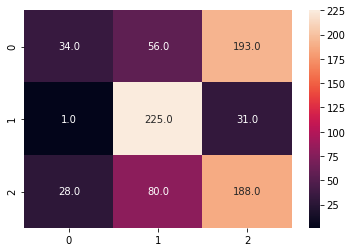

Accuracy: 0.534688995215311

Best max depth : 5
Best max size : 5

-------------------------------------
[X6 < 0.144]
 [X6 < 0.093]
  [X7 < 0.070]
   [X1 < 0.360]
    [X3 < 0.085]
     [I]
     [I]
    [X1 < 0.365]
     [I]
     [I]
   [X5 < 0.090]
    [X4 < 0.197]
     [I]
     [M]
    [X3 < 0.115]
     [I]
     [I]
  [X5 < 0.204]
   [X1 < 0.470]
    [X7 < 0.130]
     [I]
     [M]
    [X6 < 0.132]
     [I]
     [F]
   [X4 < 0.573]
    [X7 < 0.190]
     [I]
     [M]
    [X1 < 0.520]
     [M]
     [I]
 [X4 < 0.946]
  [X7 < 0.350]
   [X6 < 0.227]
    [X5 < 0.200]
     [F]
     [M]
    [X2 < 0.465]
     [M]
     [F]
   [X1 < 0.580]
    [X1 < 0.565]
     [M]
     [M]
    [M]
  [X5 < 0.874]
   [X2 < 0.535]
    [X5 < 0.480]
     [F]
     [M]
    [X1 < 0.755]
     [F]
     [M]
   [X2 < 0.565]
    [X1 < 0.580]
     [F]
     [M]
    [X7 < 0.621]
     [M]
     [M]
Confusion matrix:


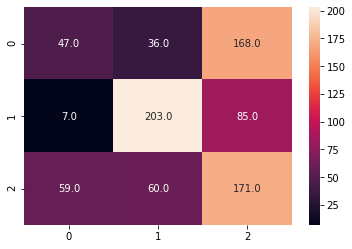

Accuracy: 0.5035885167464115

Best max depth : 5
Best max size : 5

-------------------------------------
[X6 < 0.144]
 [X7 < 0.129]
  [X3 < 0.105]
   [X3 < 0.075]
    [X6 < 0.011]
     [I]
     [I]
    [X5 < 0.082]
     [I]
     [I]
   [X1 < 0.420]
    [X7 < 0.095]
     [I]
     [F]
    [X6 < 0.096]
     [I]
     [I]
  [X1 < 0.510]
   [X4 < 0.633]
    [X6 < 0.114]
     [I]
     [F]
    [X1 < 0.505]
     [M]
     [F]
   [X7 < 0.265]
    [X4 < 0.722]
     [I]
     [I]
    [X2 < 0.450]
     [M]
     [F]
 [X4 < 0.875]
  [X1 < 0.540]
   [X3 < 0.145]
    [X4 < 0.718]
     [M]
     [M]
    [X6 < 0.169]
     [F]
     [F]
   [X4 < 0.785]
    [X7 < 0.250]
     [I]
     [M]
    [X7 < 0.213]
     [F]
     [M]
  [X5 < 0.874]
   [X6 < 0.299]
    [X5 < 0.560]
     [M]
     [M]
    [X2 < 0.530]
     [F]
     [F]
   [X1 < 0.720]
    [X4 < 1.675]
     [F]
     [M]
    [X6 < 0.541]
     [M]
     [M]
Confusion matrix:


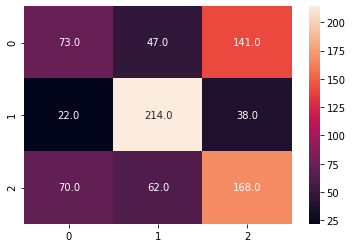

Accuracy: 0.5449101796407185

Best max depth : 5
Best max size : 5

-------------------------------------
[X6 < 0.127]
 [X7 < 0.116]
  [X3 < 0.115]
   [X5 < 0.147]
    [X4 < 0.348]
     [I]
     [F]
    [X1 < 0.480]
     [I]
     [M]
   [X1 < 0.420]
    [X6 < 0.056]
     [I]
     [F]
    [X6 < 0.106]
     [I]
     [F]
  [X1 < 0.495]
   [X4 < 0.541]
    [X1 < 0.470]
     [I]
     [I]
    [X4 < 0.592]
     [M]
     [M]
   [X7 < 0.236]
    [X3 < 0.170]
     [I]
     [F]
    [X1 < 0.500]
     [M]
     [F]
 [X4 < 0.875]
  [X6 < 0.172]
   [X5 < 0.200]
    [X4 < 0.556]
     [I]
     [F]
    [X5 < 0.319]
     [M]
     [I]
   [X1 < 0.555]
    [X4 < 0.818]
     [F]
     [M]
    [X4 < 0.780]
     [I]
     [M]
  [X6 < 0.243]
   [X6 < 0.240]
    [X5 < 0.691]
     [M]
     [M]
    [X3 < 0.150]
     [F]
     [M]
   [X5 < 0.874]
    [X2 < 0.535]
     [F]
     [F]
    [X2 < 0.625]
     [M]
     [F]
Confusion matrix:


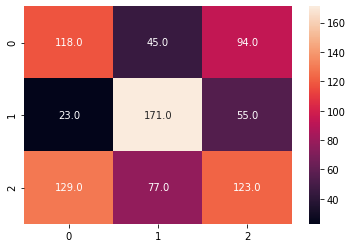

Accuracy: 0.4934131736526946

Best max depth : 5
Best max size : 5

-------------------------------------
[X6 < 0.149]
 [X7 < 0.115]
  [X7 < 0.048]
   [X4 < 0.275]
    [X3 < 0.100]
     [I]
     [M]
    [F]
   [X5 < 0.068]
    [X1 < 0.345]
     [I]
     [M]
    [X1 < 0.420]
     [I]
     [I]
  [X1 < 0.510]
   [X7 < 0.174]
    [X5 < 0.200]
     [I]
     [I]
    [X6 < 0.107]
     [M]
     [F]
   [X4 < 0.702]
    [X7 < 0.193]
     [I]
     [I]
    [X7 < 0.265]
     [I]
     [F]
 [X4 < 0.945]
  [X4 < 0.852]
   [X1 < 0.540]
    [X2 < 0.425]
     [M]
     [F]
    [X5 < 0.256]
     [M]
     [I]
   [X7 < 0.350]
    [X6 < 0.239]
     [M]
     [F]
    [X1 < 0.580]
     [M]
     [M]
  [X5 < 0.875]
   [X6 < 0.312]
    [X5 < 0.562]
     [F]
     [M]
    [X1 < 0.755]
     [F]
     [M]
   [X1 < 0.745]
    [X3 < 0.175]
     [F]
     [M]
    [X2 < 0.585]
     [F]
     [M]
Confusion matrix:


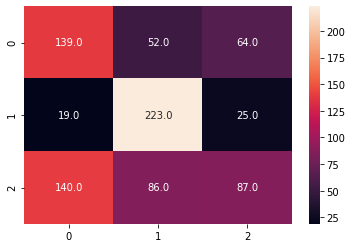

Accuracy: 0.5377245508982036
-------------------------------------
Scores: [0.534688995215311, 0.5035885167464115, 0.5449101796407185, 0.4934131736526946, 0.5377245508982036]
Mean score:  0.5228650832306678


In [ ]:
score = applyDT(X, y, prune=True)
print("Mean score: ", score)